In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,PrecisionRecallDisplay
import pickle
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced

In [3]:
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('scikit-learn:',sklearn.__version__)
print('imblearn:',imblearn.__version__)

numpy: 2.2.3
pandas: 2.2.3
scikit-learn: 1.6.1
imblearn: 0.13.0


In [4]:
df = pd.read_csv('diabetes.csv')

In [37]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
130,4,173.0,70.0,14.0,168.00,29.7,0.361,33.0,1
534,1,77.0,56.0,30.0,56.00,33.3,1.251,24.0,0
757,0,123.0,72.0,27.5,249.25,36.3,0.258,52.0,1
183,5,73.0,60.0,26.0,42.75,26.8,0.268,27.0,0
497,2,81.0,72.0,15.0,76.00,30.1,0.547,25.0,0


In [6]:
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age',]
for col in zero_cols:
    df[col] = df[col].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=4)
df[zero_cols] = imputer.fit_transform(df[zero_cols])

In [7]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.132048,0.214034,0.104116,0.058938,0.022870,-0.033523,0.544341,0.221898
Glucose,0.132048,1.000000,0.235341,0.250417,0.620562,0.238001,0.139962,0.270892,0.496679
BloodPressure,0.214034,0.235341,1.000000,0.226044,0.131237,0.288897,0.006893,0.337302,0.175010
SkinThickness,0.104116,0.250417,0.226044,1.000000,0.246282,0.640623,0.113777,0.152523,0.282764
Insulin,0.058938,0.620562,0.131237,0.246282,1.000000,0.247972,0.142367,0.224939,0.308523
BMI,0.022870,0.238001,0.288897,0.640623,0.247972,1.000000,0.154136,0.027736,0.313360
DiabetesPedigreeFunction,-0.033523,0.139962,0.006893,0.113777,0.142367,0.154136,1.000000,0.033561,0.173844
Age,0.544341,0.270892,0.337302,0.152523,0.224939,0.027736,0.033561,1.000000,0.238356
Outcome,0.221898,0.496679,0.175010,0.282764,0.308523,0.313360,0.173844,0.238356,1.000000


In [12]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

<Axes: xlabel='Outcome', ylabel='Count'>

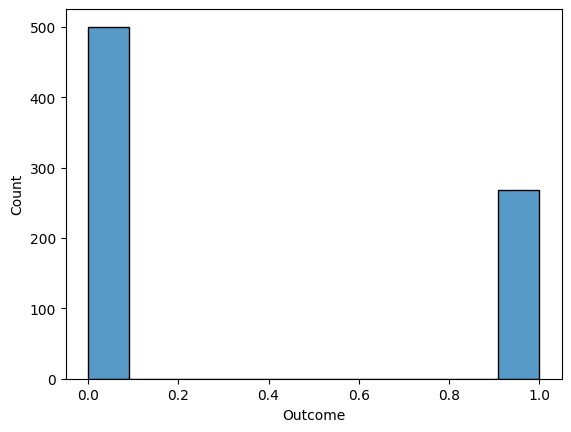

In [13]:
sns.histplot(data=df, x="Outcome")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


In [17]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.596680,72.264648,29.064779,153.198893,32.428971,0.471876,33.240885,0.348958
std,3.369578,30.526785,12.203880,9.528484,99.545916,6.885049,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,23.000000,87.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,132.125000,32.150000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,35.000000,189.312500,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


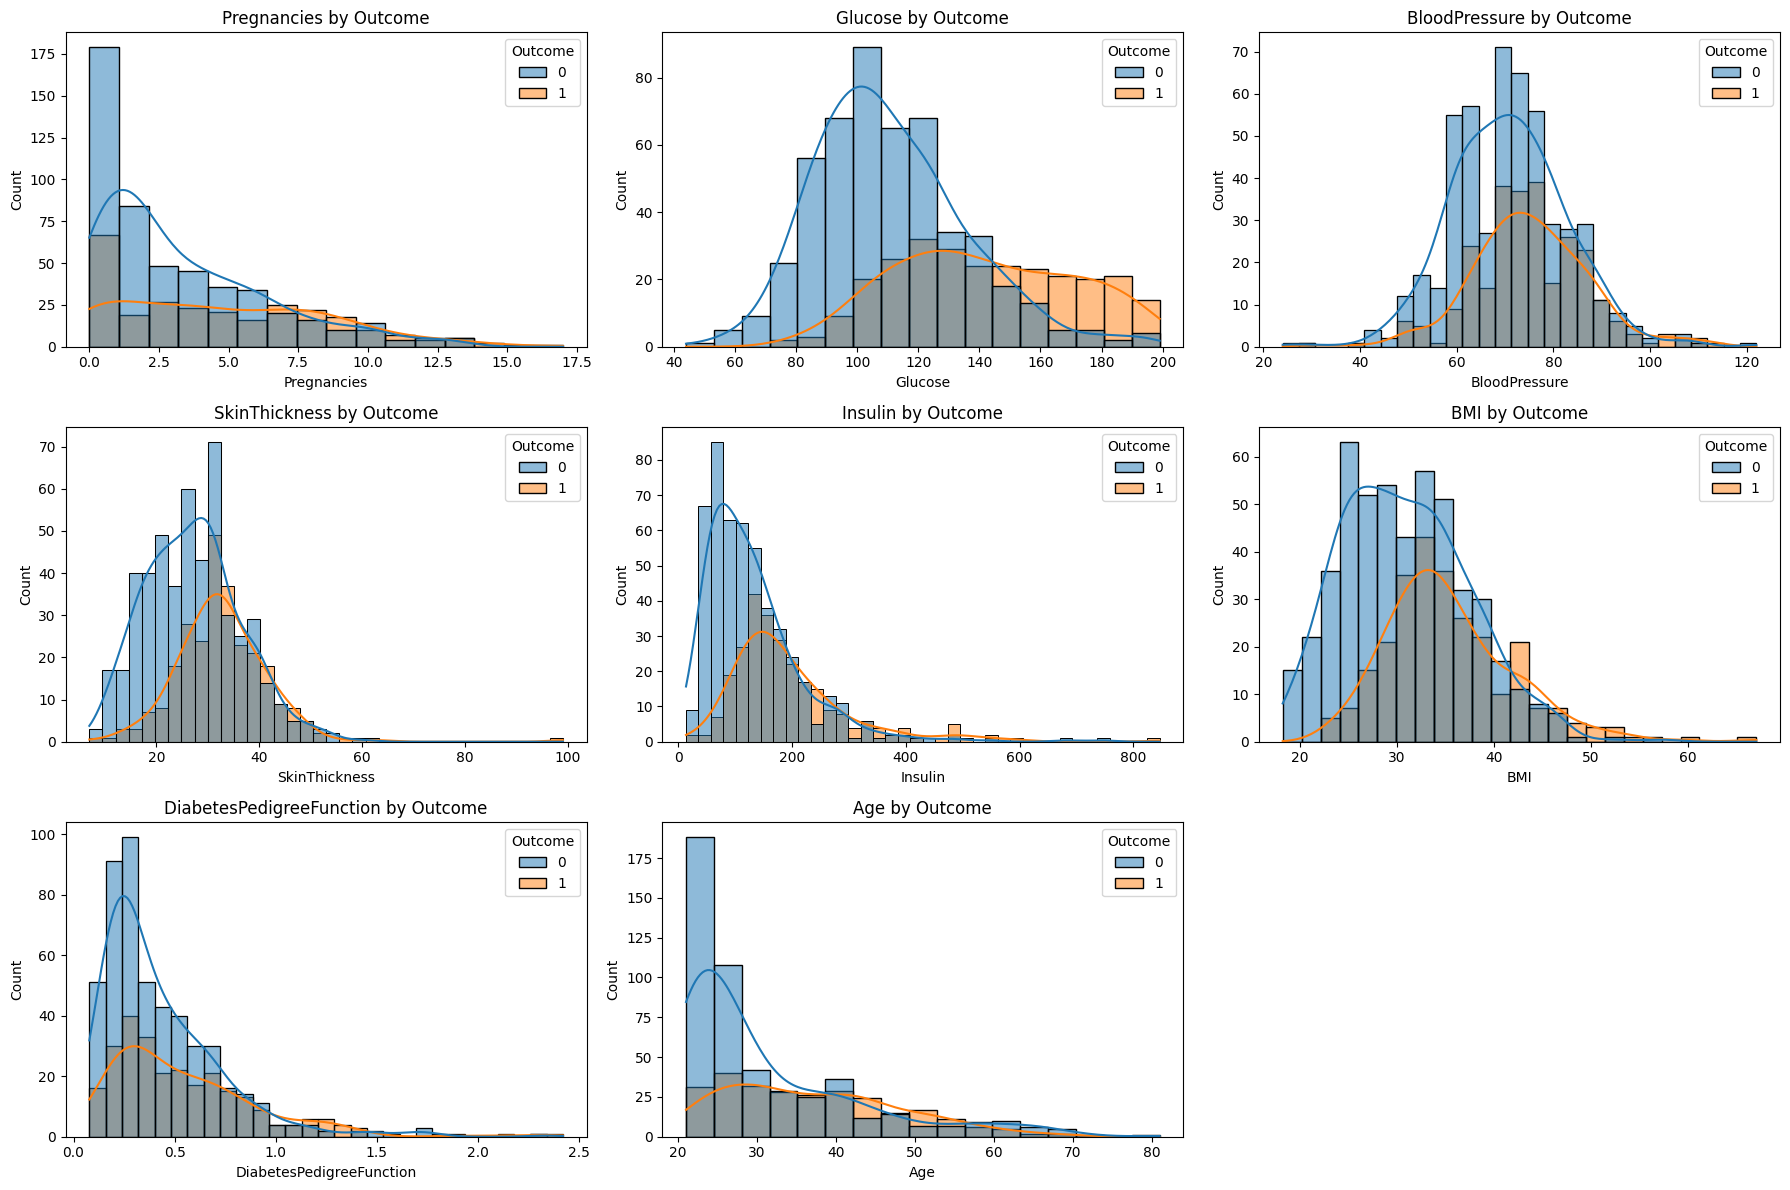

In [18]:
features = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, hue="Outcome", kde=True, ax=axes[i])
    axes[i].set_title(f"{feature} by Outcome")

for j in range(len(features), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [19]:
features = df.drop(columns=['Outcome'])
for i in features:
    count = (df[i]==0).sum()
    print(f"{i}:{count}")

Pregnancies:111
Glucose:0
BloodPressure:0
SkinThickness:0
Insulin:0
BMI:0
DiabetesPedigreeFunction:0
Age:0


In [20]:
X = df.drop(columns='Outcome')
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [21]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((576, 8), (192, 8), (576,), (192,))

In [22]:
info = mutual_info_classif(X_train, y_train,random_state=42)
info = pd.Series(info)
info.index = X_train.columns
info.sort_values(ascending=False)

Glucose                     0.138783
Age                         0.113079
Insulin                     0.093477
Pregnancies                 0.072484
BMI                         0.065976
SkinThickness               0.040679
DiabetesPedigreeFunction    0.024418
BloodPressure               0.000000
dtype: float64

In [23]:
X_train = X_train.drop(columns=['BloodPressure','DiabetesPedigreeFunction','SkinThickness'])
X_test = X_test.drop(columns=['BloodPressure','DiabetesPedigreeFunction','SkinThickness'])

In [24]:
sm = SMOTE(random_state=42,k_neighbors=4)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [25]:
lgbm = LGBMClassifier(n_estimators=3,max_depth=3,learning_rate=1,metric='f1',objective='binary',random_state=42,verbose=0,class_weight={0: 0.1, 1: 1})

In [26]:
cb = CatBoostClassifier(iterations=100,depth=3,learning_rate=0.1,eval_metric='F1',loss_function='Logloss',verbose=False,random_state=42,
                        class_weights=[0.1, 2])

In [27]:
brf = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, max_depth=2, random_state=0,bootstrap=False,verbose=0,class_weight='balanced')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


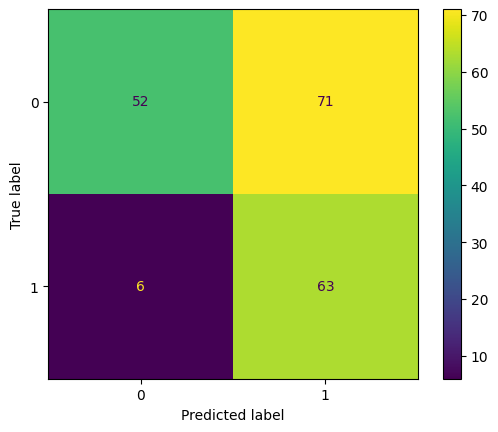

In [28]:
eclf1 = VotingClassifier(estimators=[
         ('best_clf',brf),('lgbm',lgbm),('cb',cb)], voting='hard')
eclf1.fit(X_res, y_res)
eclf1_pred = eclf1.predict(X_test)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, eclf1_pred, labels=eclf1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=eclf1.classes_)
disp.plot()
plt.show()

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


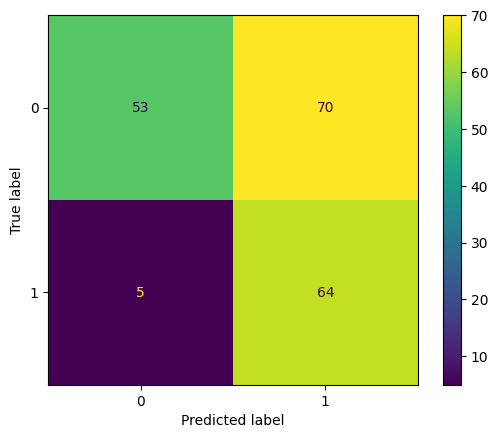

In [29]:
soft_eclf1 = VotingClassifier(estimators=[
         ('best_clf',brf),('lgbm',lgbm),('cb',cb)], voting='soft')
soft_eclf1.fit(X_res, y_res)
eclf1_pred = soft_eclf1.predict(X_test)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, eclf1_pred, labels=soft_eclf1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=soft_eclf1.classes_)
disp.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.67      0.76       123
           1       0.59      0.84      0.69        69

    accuracy                           0.73       192
   macro avg       0.73      0.75      0.72       192
weighted avg       0.78      0.73      0.73       192



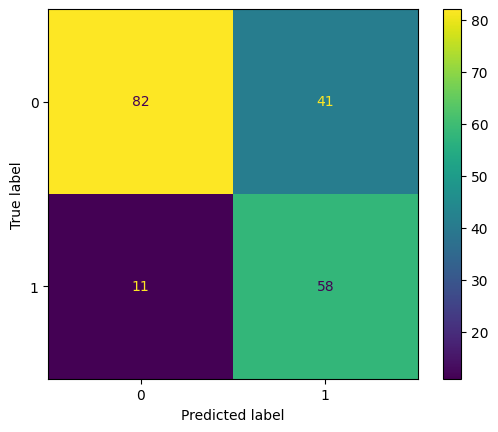

In [30]:
estimators = [
    ('best_clf', brf),   
    ('lgbm', lgbm),      
    ('cb', cb)           
]

final_estimator = LogisticRegression(max_iter=1000, random_state=42)

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,  
    passthrough=False,  
    stack_method='auto',  
    n_jobs=-1
)

stack_clf.fit(X_res, y_res)

stack_pred = stack_clf.predict(X_test)


print(classification_report(y_test, stack_pred))
cm = confusion_matrix(y_test, stack_pred, labels=stack_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=stack_clf.classes_)
disp.plot()
plt.show()


In [32]:
print(classification_report_imbalanced(y_test, stack_pred)) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.67      0.84      0.76      0.75      0.55       123
          1       0.59      0.84      0.67      0.69      0.75      0.57        69

avg / total       0.78      0.73      0.78      0.73      0.75      0.56       192



In [33]:
calibrated_clf = CalibratedClassifierCV(stack_clf, cv=10)
calibrated_clf.fit(X_res,y_res)
calibrated_clf_pred = calibrated_clf.predict(X_test)
print(classification_report_imbalanced(y_test, calibrated_clf_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.64      0.86      0.75      0.74      0.54       123
          1       0.57      0.86      0.64      0.69      0.74      0.56        69

avg / total       0.77      0.72      0.78      0.72      0.74      0.55       192



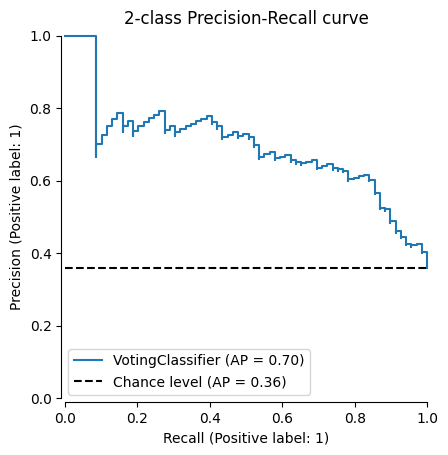

In [34]:
display = PrecisionRecallDisplay.from_estimator(
    calibrated_clf, X_test, y_test, name="VotingClassifier", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [35]:
with open('diabetesModel.pkl', 'wb') as file:
    pickle.dump(calibrated_clf, file)